## 4.3 データを取得する

1. house Pricesコンペのページkらでーたをダウンロードする
2. ディレクトリ構成
3. 必要なライブラリをインポートする
4. ランダムシードの設定
5. CSVデータを読み込む

In [96]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
plt.style.use('ggplot')

In [98]:
# ランダムシードの設定
import random

np.random.seed(1234)
random.seed(1234)

In [99]:
# CSVデータを読み込む

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [100]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 4.4 ベースライン（ベンチマーク）を作成する

1. LightBGMで予測する
   1. 学習データの各変数の型を確認する
   2. 学習データとテストデータの連結して前処理を行う
   3. カテゴリ変数を数値に変換する
   4. 欠損値を数値に変換する
   5. 再び学習データとテストデータに戻す
   6. LightGBMに上記データを読み込ませる
2. クロスバリデーションを用いてモデルの学習・予測を行う
   1. クロスバリデーション用のライブラリを読み込んで分割数を設定する
      1. ハイパーパラメータを設定する
      2. 説明変数、目的変数を指定する
      3. 平均二乗誤差を出すライブラリをインポートする
      4. 各foldごとに作成したモデルごとの予測値を保存する
      5. 平均RMSEを計算する
      6. 現状の予測値と実際の値の違いを確認する
   2. 各変数の重要度を確認する
      1. 表示する変数の数を制限する

In [101]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [102]:
train_df["MSZoning"].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [103]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [104]:
all_df["SalePrice"]

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

In [105]:
from sklearn.preprocessing import LabelEncoder

In [106]:
categories = all_df.columns[all_df.dtypes == 'object']

print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [107]:
all_df["Alley"].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [108]:
for cat in categories:
    le = LabelEncoder()
    print(cat)

    all_df[cat].fillna("missing", inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_76515/2639677646.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df[cat].fillna("missing", inplace=True)
/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_76515/2639677646.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [109]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


In [110]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [111]:
import lightgbm as lgb
from sklearn.model_selection import KFold

In [112]:
folds = 3
kf = KFold(n_splits=folds)

In [113]:
lgbm_params = {
    "objective": "regression",
    "random_seed": 1234,
}

In [114]:
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1)
train_Y = train_df_le["SalePrice"]

In [115]:
from sklearn.metrics import mean_squared_error

In [116]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[val_index]
    y_train, y_valid = train_Y.iloc[train_index], train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=100,
        callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(stopping_rounds=20)],
        )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))

    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 5.37132e+08
0.12800381488672496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 180923.739979
Training until validation scores do

In [117]:
sum(rmses) / len(rmses)

np.float64(0.1352849504777467)

In [118]:
actual_pred_df = pd.DataFrame({
    "actual": train_Y,
    "pred": oof
})

<Axes: >

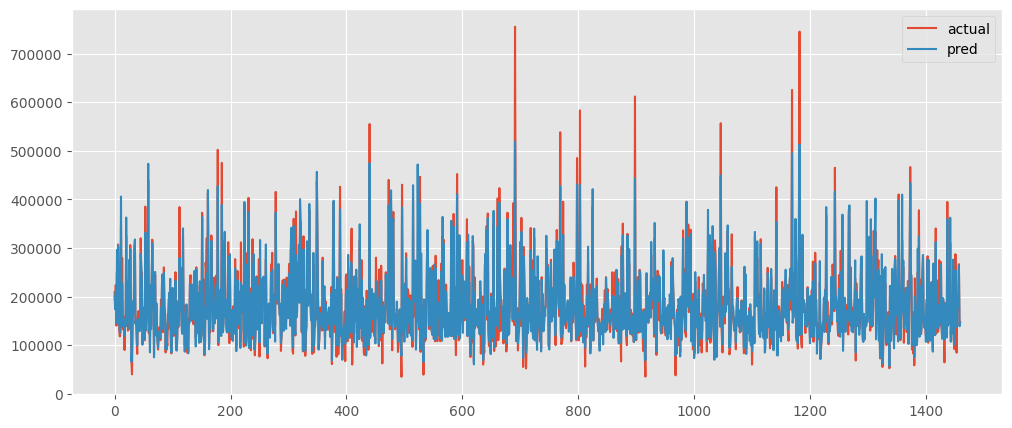

In [119]:
actual_pred_df.plot(figsize=(12, 5))

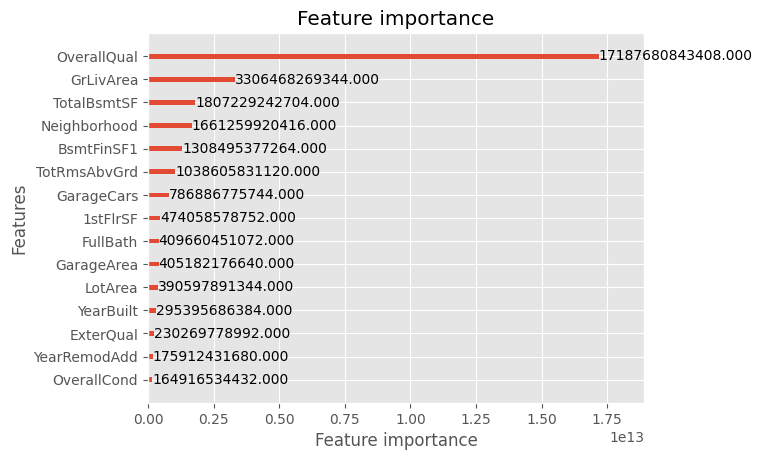

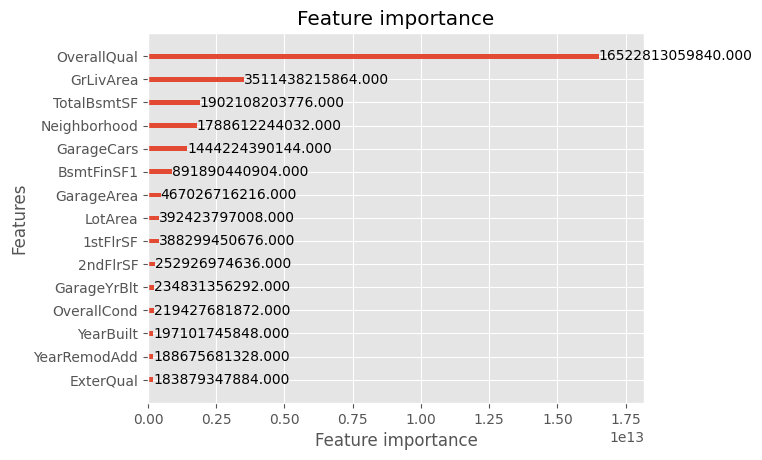

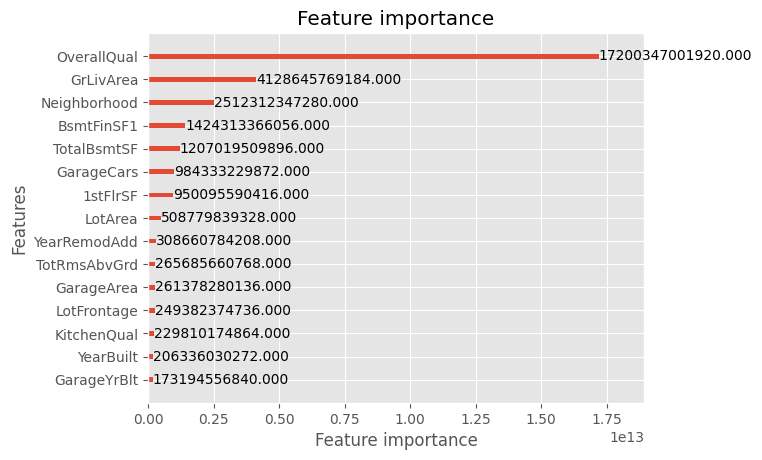

In [120]:
for model in models:
    lgb.plot_importance(model, importance_type="gain", max_num_features=15)